In [1]:
import math
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import json_normalize
import yaml
from yaml import CSafeLoader as Loader

sns.set_context("paper", font_scale=2.1)
sns.set_style("whitegrid")

LOG_DIR = "./lightning_logs_final/"

REFERENCE_METRIC = "val_acc"

In [2]:
# Remove superfluous NaN cells
def compress(values):
    for val in values:
        if val is not None and not np.isnan(val):
            return val
        
results_df = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    run_path = os.path.join(LOG_DIR, run_dir, "checkpoints/")

    results = glob.glob(run_path+f"*{REFERENCE_METRIC}=*.pickle")
    if len(results) < 1:
        run_path = os.path.join(LOG_DIR, run_dir)
        results = glob.glob(run_path+f"/*.pickle")
        # if len(results) >= 1:
        #     print(f"considering pre-final results for run {run_dir[8:]}")

    for result in results:
        try:
            data = pd.read_pickle(result)
        except Exception as e:
            print(result)
            print(e)
            continue
            
        if isinstance(data, list):
            df = pd.DataFrame.from_records(data)
            df = df.groupby(["dir_name", "epoch"]).aggregate(compress)
        else:
            if "receiver_aux_loss" in data.keys():
                data["receiver_auxiliary_loss"] = data["receiver_aux_loss"]
                del data["receiver_aux_loss"]
            df = pd.DataFrame.from_records([data])
        
        df["dir_name"] = run_dir
        if "epoch" in result:
            df["epoch"] = int(result.split("epoch=")[1].split("-")[0])
        results_df.append(df)


results_df = pd.concat(results_df, ignore_index=True)

results_df.reset_index(inplace=True)
results_df

100%|████████████████████████████████████████| 354/354 [00:01<00:00, 211.94it/s]


,index,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,sender_policy_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc,train_acc_no_noise,train_acc_no_noise_at_best_val_acc,num_unique_messages,...,receiver_aux_acc/dataloader_idx_1,topsim_sender_receiver,posdis_sender_receiver,bosdis_sender_receiver,receiver_loss,entropy_loss,sender_policy_loss,train_acc,receiver_auxiliary_loss,receiver_aux_acc
0,0,7.517605,0.005849,2.913938,0.924113,0.946572,0.924113,0.990029,0.990029,70641.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,0.924113,0.946572,0.924113,0.990029,0.990029,70641.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1.563670,0.000435,0.122196,0.434161,0.635225,0.434161,0.649232,0.649232,720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,0.434161,0.635225,0.434161,0.649232,0.649232,720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.081216,0.000060,0.082980,0.931100,0.983050,0.931100,0.979960,0.979960,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,659,0.472237,0.000195,0.156964,0.745981,0.871749,0.745981,0.905236,0.905236,5499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
660,660,NaN,NaN,NaN,0.745981,0.871749,0.745981,0.905236,0.905236,5499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,661,NaN,NaN,NaN,0.227667,0.229000,0.227667,0.206667,0.206667,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662,662,0.873195,0.000349,0.315364,0.915012,0.922104,0.915012,0.978996,0.978996,50106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
hp = []
for run_dir in tqdm(os.listdir(LOG_DIR)):
    file_path = os.path.join(LOG_DIR, run_dir, "hparams.yaml")
    file = yaml.load(open(file_path), Loader=Loader) #safe_load(, Loader=Loader)
    df = json_normalize(file)
    df["dir_name"] = run_dir
    hp.append(df)

hp = pd.concat(hp, ignore_index=True)
hp

100%|████████████████████████████████████████| 354/354 [00:00<00:00, 527.99it/s]


,accelerator,accumulate_grad_batches,amp_backend,amp_level,auto_lr_find,auto_scale_batch_size,auto_select_gpus,baseline_type,batch_size,benchmark,...,flush_logs_every_n_steps,log_gpu_memory,prepare_data_per_node,process_position,progress_bar_refresh_rate,receiver_ignore_candidates_for_feedback,stochastic_weight_avg,terminate_on_nan,weights_save_path,weights_summary
0,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpu,None,None,None,False,False,None,mean,1000,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,None,None,native,None,False,False,False,mean,1000,None,...,None,None,None,0.0,None,False,False,None,None,top
350,gpu,None,None,None,False,False,None,mean,1000,None,...,None,None,None,NaN,None,NaN,NaN,None,None,NaN
351,gpu,None,None,None,False,False,None,mean,1000,None,...,None,None,None,NaN,None,NaN,NaN,None,None,NaN
352,gpu,None,None,None,False,False,None,mean,1000,None,...,None,None,None,NaN,None,NaN,NaN,None,None,NaN


In [4]:
def fix_duplicate_value(val, allow_offset=None):
    if isinstance(val, list):
        for el in val:
            if allow_offset is None:
                assert (el == val[0]) or (el == "None") or (val[0] == "None")
            else:
                assert (np.abs(el - val[0]) < allow_offset) or (el == "None") or (val[0] == "None")
        return val[0]
    else:
        return val

hp = hp.applymap(fix_duplicate_value)

In [5]:
indices_best_steps = results_df.groupby("dir_name")[REFERENCE_METRIC].idxmax()

df = results_df.loc[list(indices_best_steps)].copy()
df

,index,receiver_loss/dataloader_idx_0,entropy_loss/dataloader_idx_0,sender_policy_loss/dataloader_idx_0,val_acc,val_acc_no_noise,best_val_acc,train_acc_no_noise,train_acc_no_noise_at_best_val_acc,num_unique_messages,...,receiver_aux_acc/dataloader_idx_1,topsim_sender_receiver,posdis_sender_receiver,bosdis_sender_receiver,receiver_loss,entropy_loss,sender_policy_loss,train_acc,receiver_auxiliary_loss,receiver_aux_acc
95,95,0.413052,0.000309,0.108176,0.69522,0.85639,0.69522,0.82650,0.82650,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,499,0.538167,0.000007,0.000511,0.55986,0.75663,0.55986,0.75206,0.75206,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
509,509,2.229411,0.000022,0.004415,0.98116,0.99007,0.98116,0.98856,0.98856,58.0,...,NaN,0.383111,0.249771,0.010753,NaN,NaN,NaN,NaN,NaN,NaN
345,345,1.301159,0.000349,0.158675,0.95705,0.97454,0.95705,0.98227,0.98227,200.0,...,NaN,0.110781,0.114838,0.002505,NaN,NaN,NaN,NaN,NaN,NaN
403,403,0.619943,0.000178,0.074685,0.89155,0.96381,0.89155,0.93801,0.93801,35.0,...,NaN,0.200786,0.296236,0.220224,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,9.295768,0.000263,0.121524,0.98710,0.99238,0.98710,0.99033,0.99033,400.0,...,NaN,0.205750,0.189505,0.175684,NaN,NaN,NaN,NaN,NaN,NaN
531,531,2.458331,0.000970,0.482539,0.99223,0.99223,0.99223,0.98726,0.98726,339.0,...,NaN,0.223198,0.154985,0.023719,NaN,NaN,NaN,NaN,NaN,NaN
79,79,0.040376,0.000190,0.093622,0.97584,0.99064,0.97584,0.99135,0.99135,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,248,0.120497,0.000065,0.025663,0.92411,0.97965,0.92411,0.97429,0.97429,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.set_index("dir_name", inplace=True, drop=False)
if not hp.index.name == "dir_name":
    hp.set_index("dir_name", inplace=True, verify_integrity=True)
df = df.join(hp, how="left")

In [7]:
assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.num_senders == df.num_receivers).all()
assert (df.sender_layer_norm == df.receiver_layer_norm).all()

df["entropy_coeff"] = df["sender_entropy_coeff"]
df["num_agents"] = df["num_senders"]
df["layer_norm"] = df["sender_layer_norm"]

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)

data = df

In [8]:
def calc_capacity(row):
    return math.pow(row.num_values, row.num_attributes)

data["capacity"] = data.apply(calc_capacity, axis=1)
data.sort_values("capacity", inplace=True)

In [9]:
data["test_acc"] = data["val_acc"]
data["test_acc_no_noise"] = data["val_acc_no_noise"]

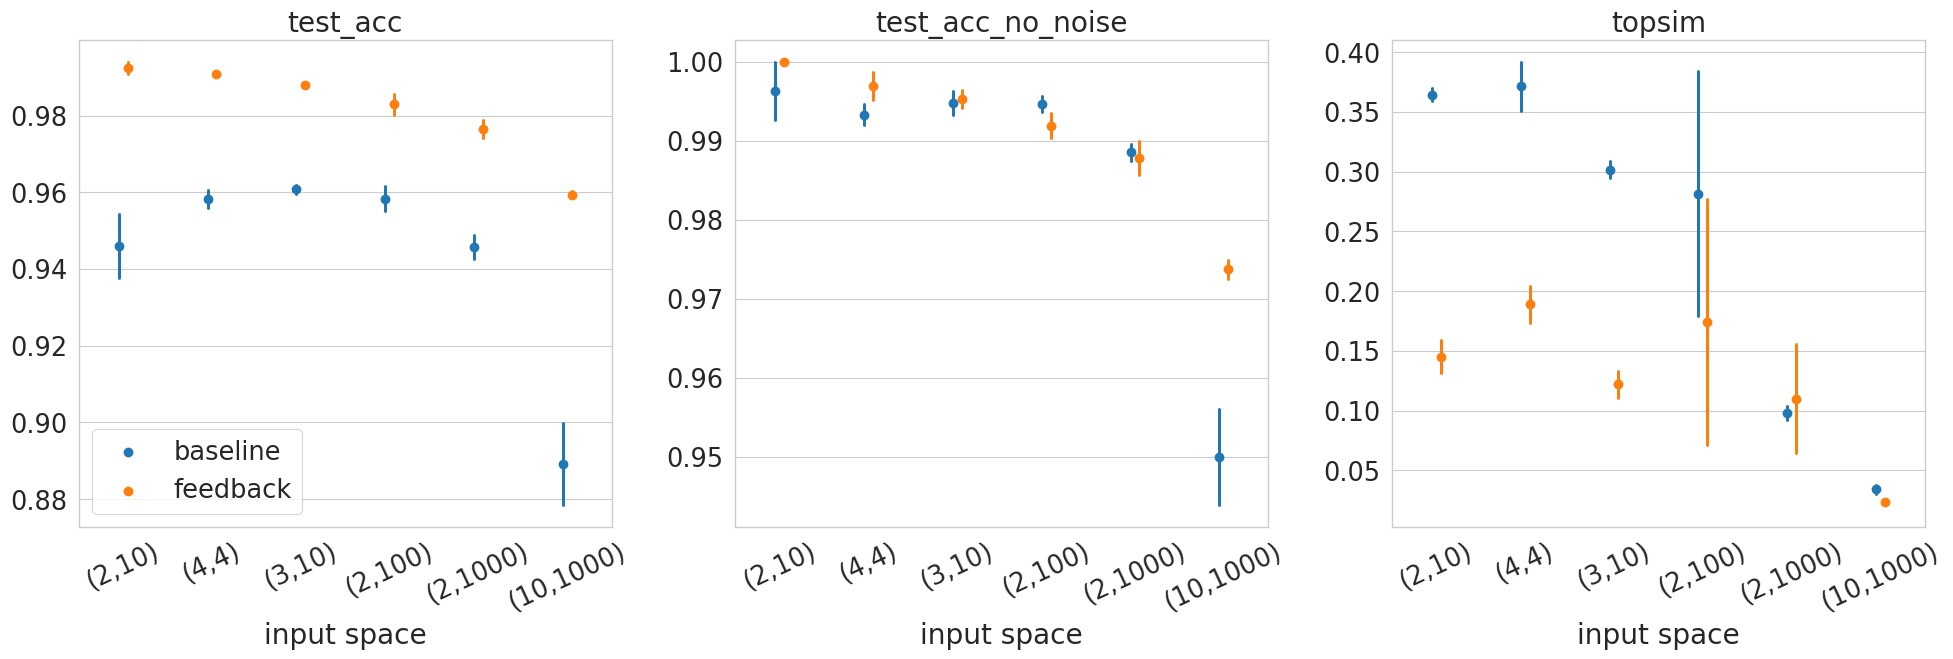

In [10]:
data["condition"] = data["noise"].map(lambda x: f"noise_{x}" if x > 0 else "baseline") + data["feedback"].map(lambda x: "_feedback" if x else "") + data["receiver_aux_loss"].map(lambda x: "_aux_loss" if x else "")

target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

NOISE = 0.5
target_data = target_data[target_data.noise == NOISE]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

hue_order = ["noise_0.5", "noise_0.5_feedback", "noise_0.5_feedback_aux_loss"]

order = ["2_10", "4_4", "3_10", "2_100", "2_1000", "10_1000"]

target_hparam = "attr_val"

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()


metrics = ["test_acc", "test_acc_no_noise", "topsim"]
_, axes = plt.subplots(1, len(metrics), figsize=(20, 7))

for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data["feedback"] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)
            print(d)

for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", errorbar="se", linestyles="", dodge=0.1)

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")
    labels = axis.get_xticklabels()
    axis.set_xticklabels([f"({','.join(l.get_text().split('_'))})" for l in labels], rotation=25)
    axis.set_xlabel("input space")

plt.tight_layout()
plt.savefig("plots/effect_of_attr_val.pdf", dpi=300)


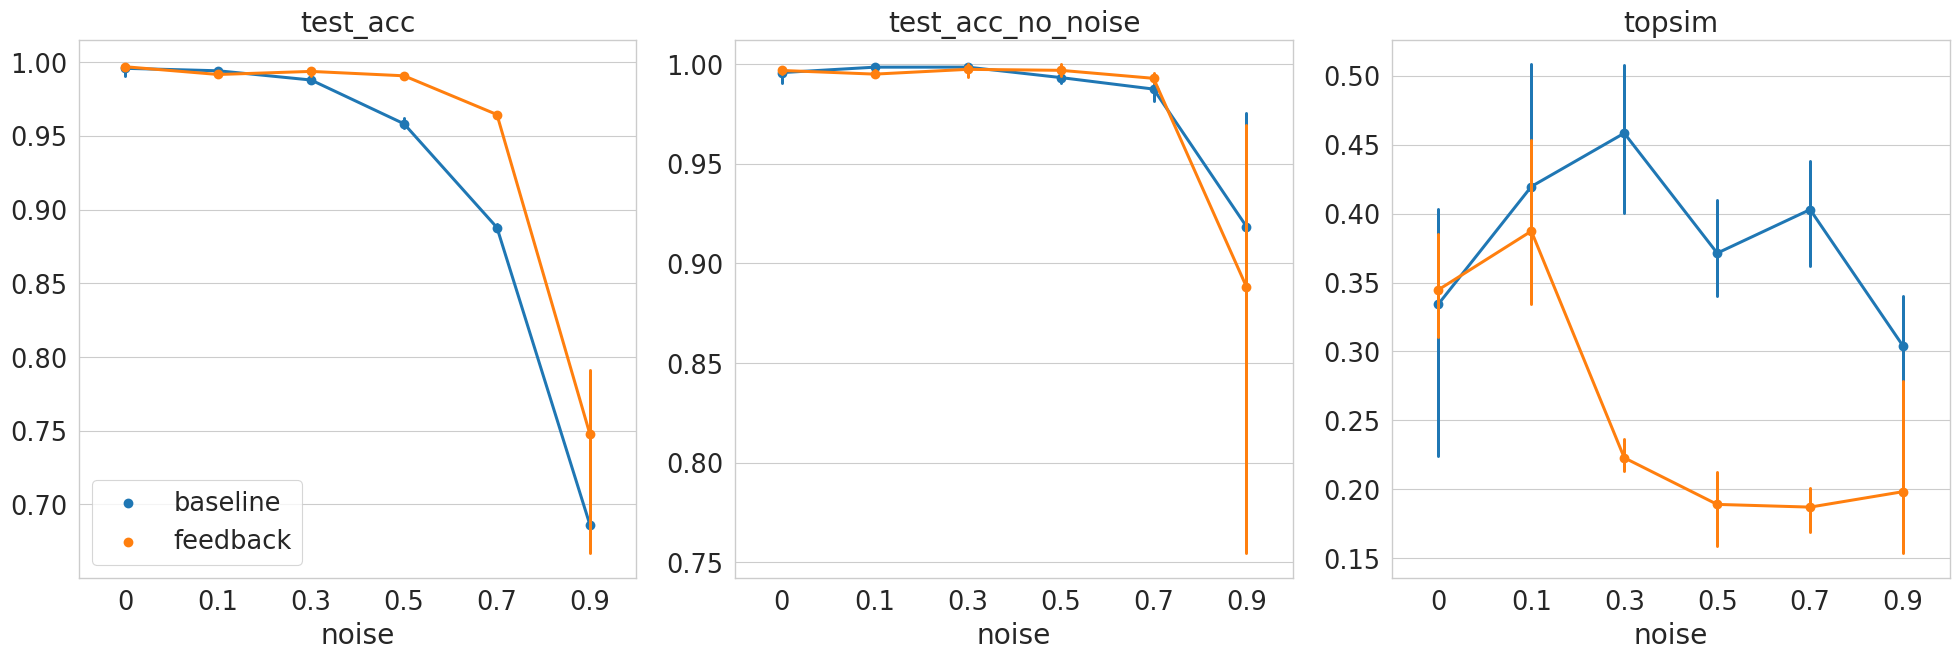

In [11]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
_, axes = plt.subplots(1, len(metrics), figsize=(20, 7))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print("fb: ", fb)
        # else:
            # print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean():.2f}+-{d['test_acc'].std():.2f}")
            # print(d.dir_name)


for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")

plt.tight_layout()
plt.savefig("plots/effect_of_noise.pdf", dpi=300)

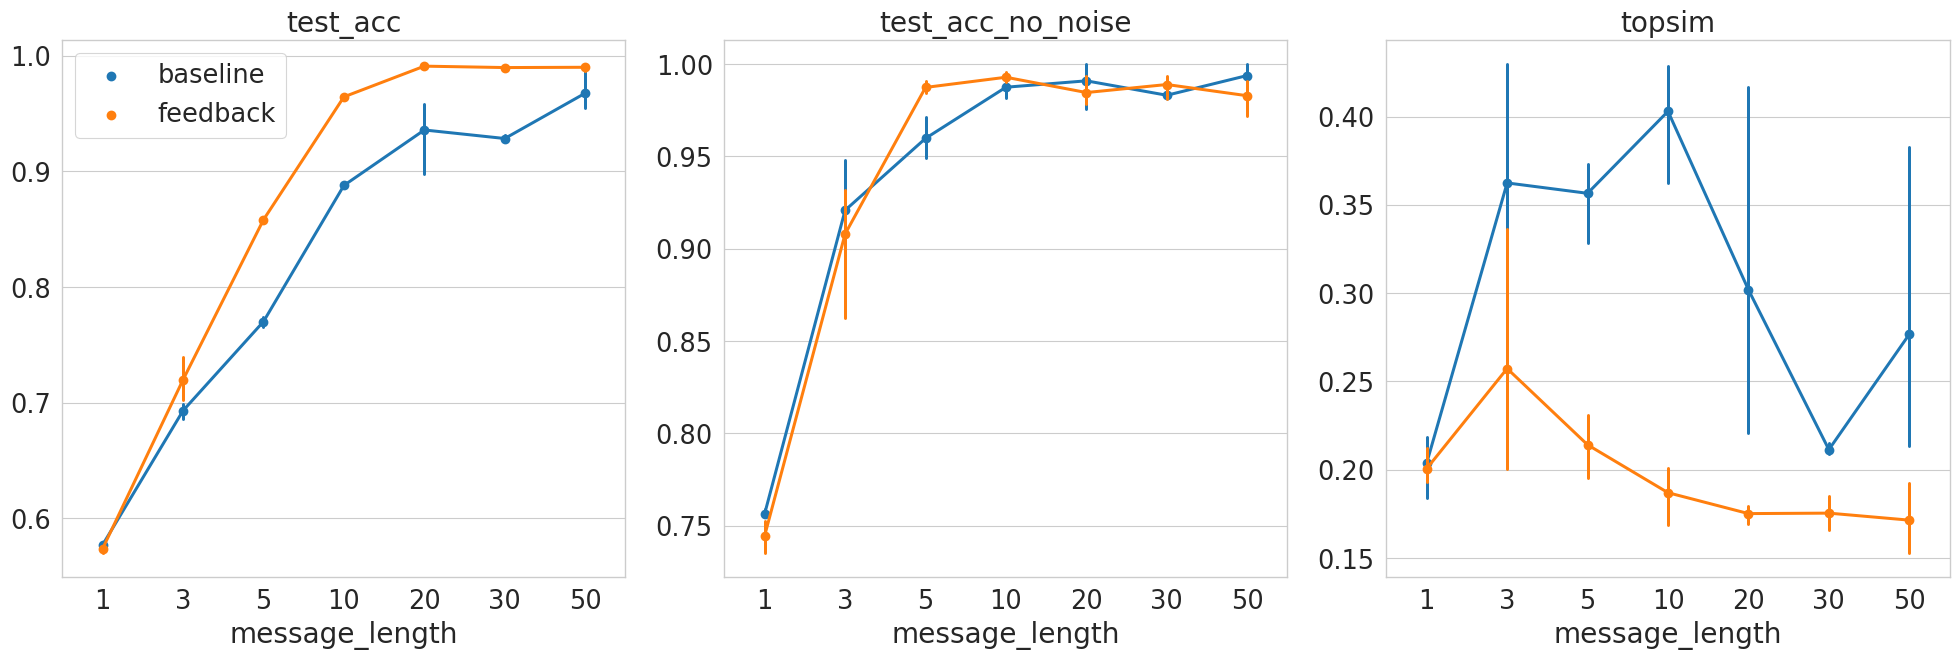

In [12]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

NOISE = 0.7
target_data = target_data[target_data.noise == NOISE]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

target_hparam = "max_len"
order = [1, 3, 5, 10, 20, 30, 50]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
_, axes = plt.subplots(1, len(metrics), figsize=(20, 7))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)
            
for i, metric in enumerate(metrics):
    axis = axes[i]
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
        sns.move_legend(axis, "upper left")
    axis.set_title(metric)
    axis.set_ylabel("")
    axis.set_xlabel("message_length")


plt.tight_layout()
plt.savefig("plots/effect_of_message_length.pdf", dpi=300)

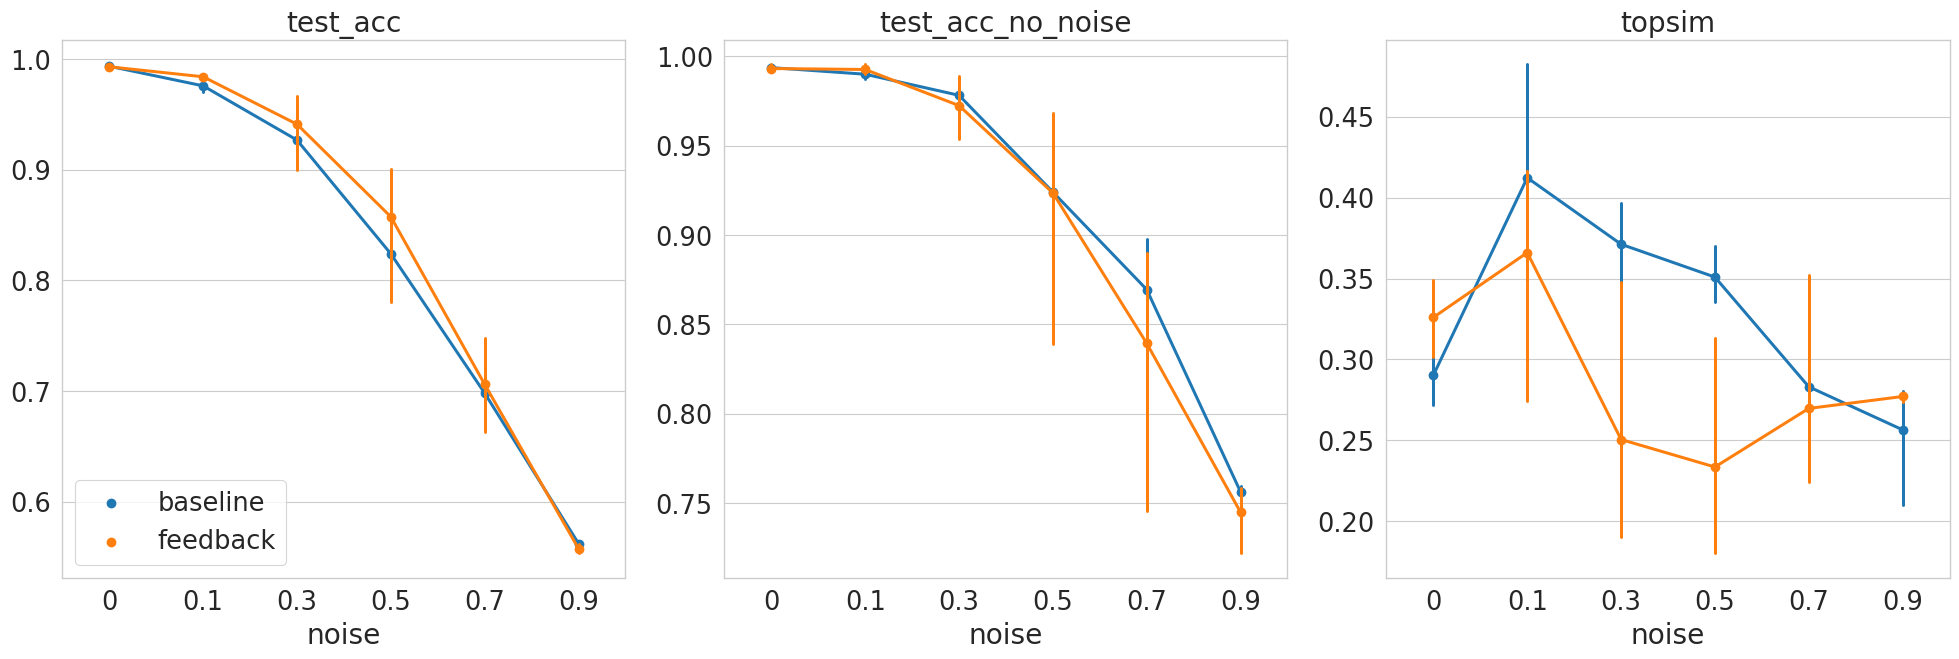

In [13]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=True
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"

target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
_, axes = plt.subplots(1, len(metrics), figsize=(20, 7))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print("fb: ", fb)
        # else:
            # print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean()}")


for i, metric in enumerate(metrics):
    axis = axes[i]
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")

plt.tight_layout()
plt.savefig("plots/effect_of_noise_alternative.pdf", dpi=300)

## Vocab size FB 10

noise: 0 | FB: True | Unexpected number of datapoints: 0
noise: 0 | FB: True | ACC: nan
noise: 0.1 | FB: True | Unexpected number of datapoints: 0
noise: 0.1 | FB: True | ACC: nan
noise: 0.3 | FB: True | Unexpected number of datapoints: 0
noise: 0.3 | FB: True | ACC: nan


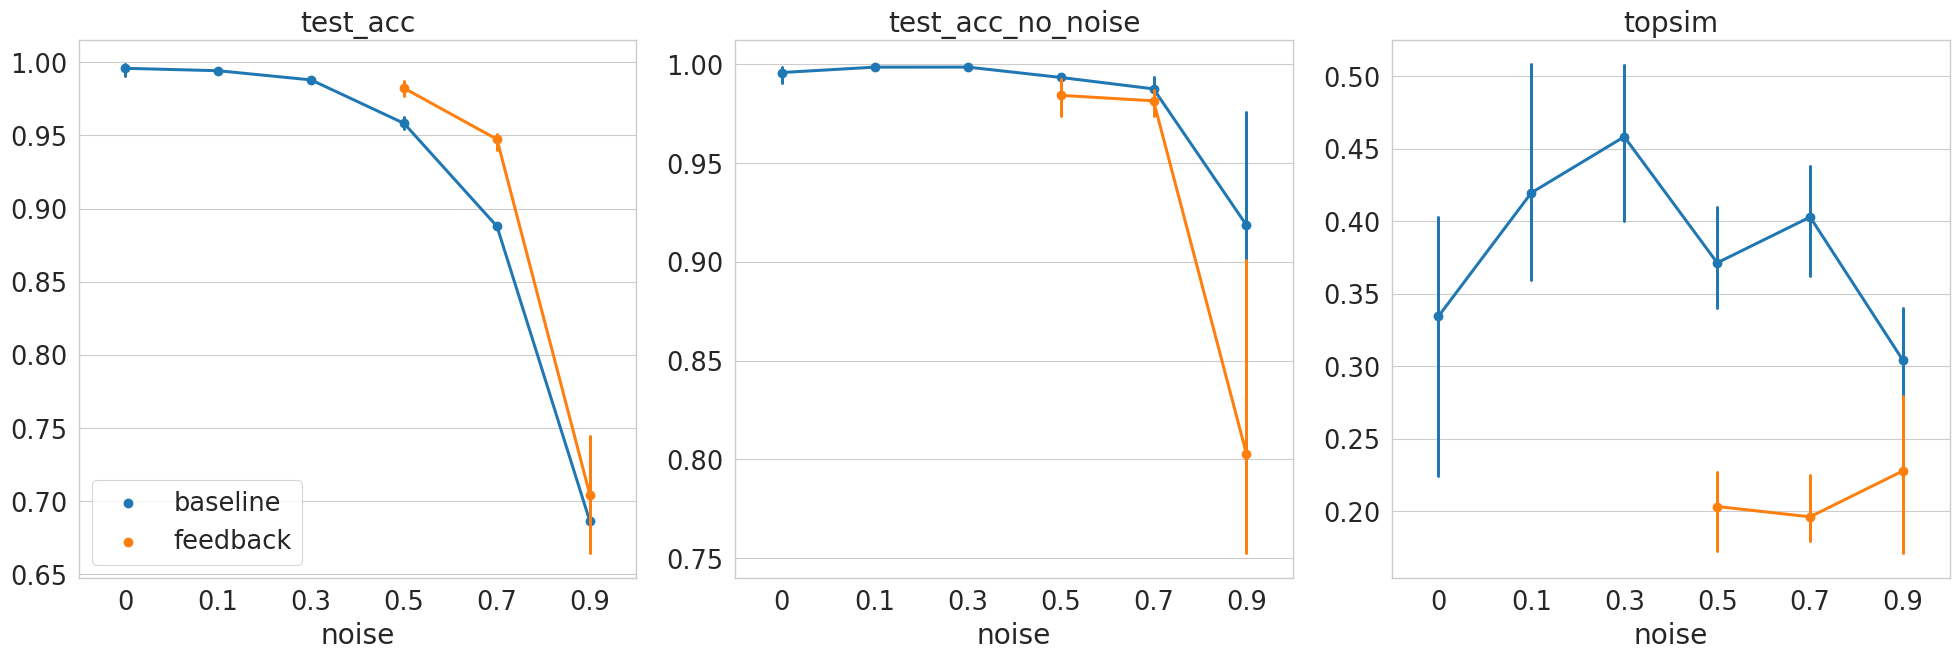

In [14]:
target_data = data.copy()

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 10
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"
target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]


num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
_, axes = plt.subplots(1, len(metrics), figsize=(20, 7))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"noise: {value} | FB: {fb} | Unexpected number of datapoints: {len(d)}")
            print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean()}")
        # else:
        #     print(f"noise: {value} | FB: {fb} | ACC: {d['test_acc'].mean()}+-{d['test_acc'].std()}")

for i, metric in enumerate(metrics):
    axis = axes[i]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")

plt.tight_layout()

## Receiver aux loss

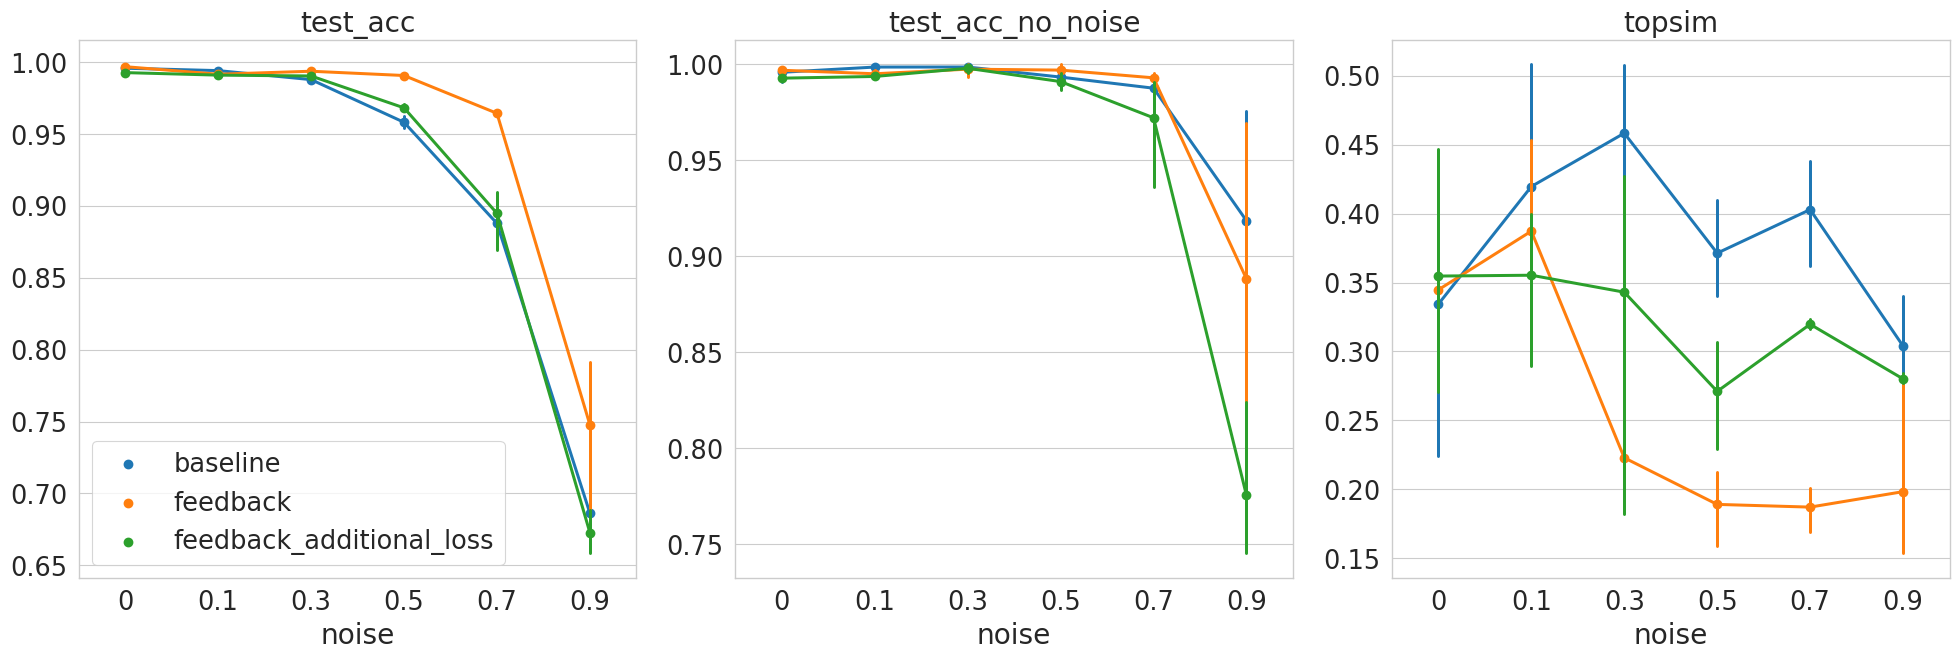

In [15]:
target_data = data.copy()

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 2
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

ATTR_VAL = "4_4"
target_data = target_data[(target_data["attr_val"] == ATTR_VAL)]

target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

target_data["hue_variable"] = data["feedback"].map(lambda x: "feedback" if x else "no_feedback") + data["receiver_aux_loss"].map(lambda x: "_noise" if x else "")

num_runs_data = target_data.groupby(["attr_val", "condition"]).size().reset_index()

metrics = ["test_acc", "test_acc_no_noise", "topsim"]
_, axes = plt.subplots(1, len(metrics), figsize=(20, 7))

hue_variable = "hue_variable"
for value in order:
    for cond in target_data.hue_variable.unique():
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == cond)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)} noise {value} | cond {cond}")
        # else:
        #     print(f"noise: {value} | cond: {cond} | ACC: {d['test_acc'].mean()}+-{d['test_acc'].std()}")
        #     print(d["dir_name"])

hue_order = ["no_feedback", "feedback", "feedback_noise"]
for i, metric in enumerate(metrics):
    axis = axes[i]
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, hue_order=hue_order, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback", "feedback_additional_loss"], handles=axis.get_legend_handles_labels()[0])
        sns.move_legend(axis, "lower left")
    axis.set_title(metric)
    axis.set_ylabel("")
    # axis.legend().set_title("")

plt.tight_layout()
plt.savefig("plots/effect_of_noise_aux_loss.pdf", dpi=300)

# Guesswhat

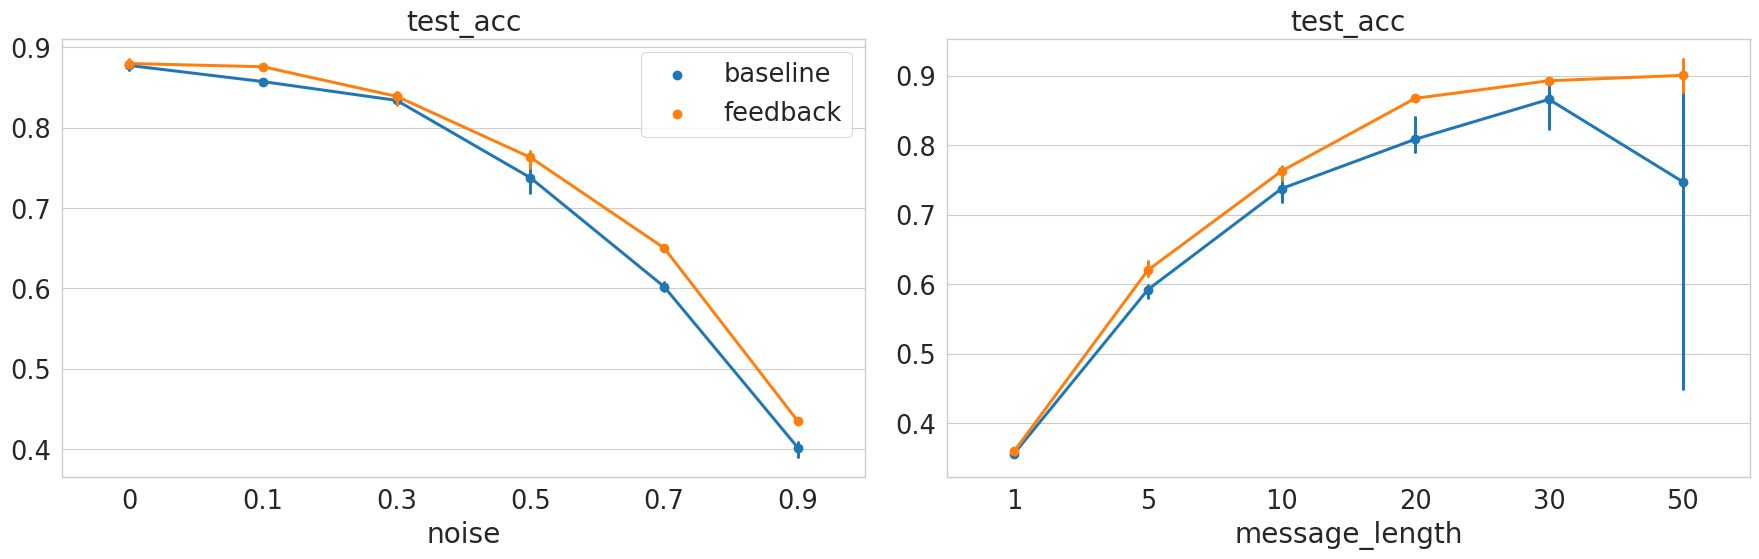

In [16]:
target_data = data.copy()

target_data = target_data[target_data.guesswhat == True]

target_data = target_data[target_data.receiver_output_attention == False]
target_data = target_data[target_data.receiver_object_attention == False]
target_data = target_data[target_data.sender_attention == False]

target_data = target_data[(target_data.receiver_aux_loss == False)]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 10
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

metrics = ["test_acc"]
_, axes = plt.subplots(1, len(metrics)*2, figsize=(18, 6))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)
            
for i, metric in enumerate(metrics):
    axis = axes[i]
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
    axis.set_title(metric)
    axis.set_ylabel("")


###
# SECOND HALF
###

target_data = data.copy()

target_data = target_data[target_data.guesswhat == True]

target_data = target_data[target_data.receiver_output_attention == False]
target_data = target_data[target_data.receiver_object_attention == False]
target_data = target_data[target_data.sender_attention == False]

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

NOISE = 0.5
target_data = target_data[target_data.noise == NOISE]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 10
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

target_hparam = "max_len"
order = [1, 5, 10, 20, 30, 50]

metrics = ["test_acc"]

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)

for i, metric in enumerate(metrics):
    axis = axes[i+len(metrics)]
    # g = sns.barplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue="feedback", dodge=True)
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    g.legend().remove()
    axis.set_title(metric)
    axis.set_ylabel("")
    axis.set_xlabel("message_length")

plt.tight_layout()
plt.savefig("plots/guesswhat.pdf", dpi=300)

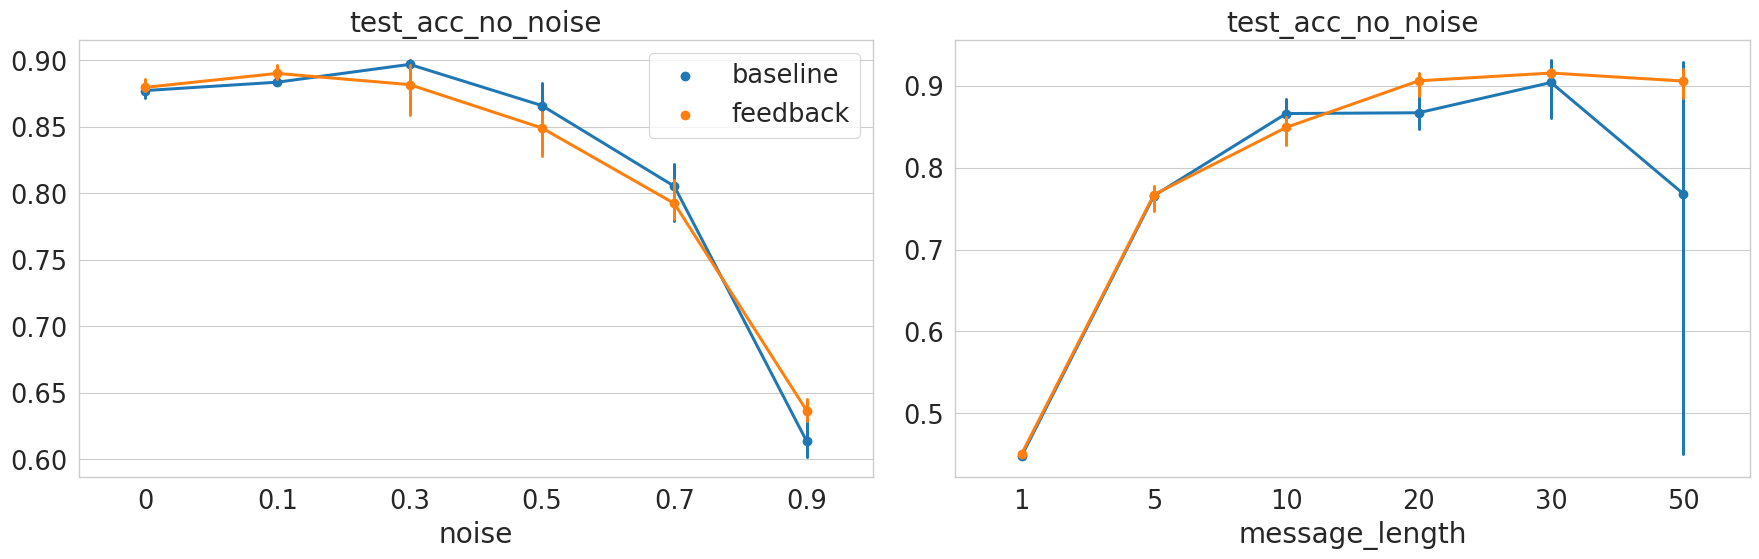

In [17]:
target_data = data.copy()

target_data = target_data[target_data.guesswhat == True]

target_data = target_data[target_data.receiver_output_attention == False]
target_data = target_data[target_data.receiver_object_attention == False]
target_data = target_data[target_data.sender_attention == False]

target_data = target_data[(target_data.receiver_aux_loss == False)]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

MAX_LEN = 10
target_data = target_data[target_data.max_len == MAX_LEN]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 10
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

target_hparam = "noise"
order = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

metrics = ["test_acc_no_noise"]
_, axes = plt.subplots(1, len(metrics)*2, figsize=(18, 6))

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)

for i, metric in enumerate(metrics):
    axis = axes[i]
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))

    if not i == 0:
        g.legend().remove()
    else:
        axis.legend(labels=["baseline", "feedback"], handles=axis.get_legend_handles_labels()[0])
    axis.set_title(metric)
    axis.set_ylabel("")


###
# SECOND HALF
###

target_data = data.copy()

target_data = target_data[target_data.guesswhat == True]

target_data = target_data[target_data.receiver_output_attention == False]
target_data = target_data[target_data.receiver_object_attention == False]
target_data = target_data[target_data.sender_attention == False]

target_data = target_data[target_data.receiver_aux_loss == False]

NOISE_PERMUTATION=False
target_data = target_data[target_data.noise_permutation == NOISE_PERMUTATION]

NUM_AGENTS = 1
target_data = target_data[target_data.num_agents == NUM_AGENTS]

NOISE = 0.5
target_data = target_data[target_data.noise == NOISE]

VOCAB_SIZE = 2
target_data = target_data[target_data.vocab_size == VOCAB_SIZE]

VOCAB_SIZE_FEEDBACK = 2
target_data = target_data[(target_data.vocab_size_feedback == VOCAB_SIZE_FEEDBACK) | (target_data.feedback == False)]

LAYER_NORM = 1
target_data = target_data[target_data.layer_norm == LAYER_NORM]

DISCRIMINATION_NUM_OBJECTS = 10
target_data = target_data[target_data.discrimination_num_objects == DISCRIMINATION_NUM_OBJECTS]

target_hparam = "max_len"
order = [1, 5, 10, 20, 30, 50]

metrics = ["test_acc_no_noise"] #

hue_variable = "feedback"
for value in order:
    for fb in [False, True]:
        d = target_data[(target_data[target_hparam] == value) & (target_data[hue_variable] == fb)]
        if len(d) != 3:
            print(f"Unexpected number of datapoints: {len(d)}")
            print(value)
            print(fb)

for i, metric in enumerate(metrics):
    axis = axes[i+len(metrics)]
    g = sns.pointplot(ax=axis, data=target_data, x=target_hparam, y=metric, order=order, hue=hue_variable, errorbar=('ci', 95))
    g.legend().remove()
    axis.set_title(metric)
    axis.set_ylabel("")
    axis.set_xlabel("message_length")

plt.tight_layout()
plt.savefig("plots/guesswhat_no_noise.pdf", dpi=300)